# <font color='green'>Homework 4</font>

<div class="alert alert-block alert-warning">
<b>
University of Tehran<br>
Fall 2022<br>
Course: Interactive Learning<br>
</div>


***

<div class="alert alert-block alert-success">
<b>Author:</b><br>
Name: Taban Soleymani <br />
Student Number: 
</div>

***

# <span style="color:purple">Importing Required Packages and Classes</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import gym
import math
import random
import sys
# import pygame
from IPython import display
np.set_printoptions(threshold=sys.maxsize)

# <span style="color:purple">Defining Variables</span>

In [2]:
global student_num
global num_of_repetition
global num_of_episodes 
global epsilon
global learning_rate
global discount_factor
global window_size
student_num = xxx
num_of_repetition = 20
num_of_episodes = 2000
epsilon = 0.5
learning_rate = 0.1
discount_factor = 0.9
window_size = 50

## <span style="color:purple">Environment</span>

In [3]:
env = gym.make('Taxi-v3', render_mode='rgb_array')
# env.reset(seed=student_num)
# env.render()

## <span style="color:purple">Agent</span>

In [4]:
class Agent(ABC):
    def __init__(self, env=env, lr=learning_rate, df=discount_factor, eps=epsilon):
        super(Agent, self).__init__()
        self.env = env
        self.lr = lr
        self.lr_min = 1e-3
        self.eps = eps
        self.eps_min = 1e-3
        self.df = df
        self.q_values = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.gt_of_all_episodes = []
        self.reward_of_all_episodes = []
        
        
    def get_epsilon_greedy_action(self, state):
        if np.random.random() < self.eps:
            return self.env.action_space.sample()
        return np.argmax(self.q_values[state])
        
    
    def reset(self):
        self.lr = learning_rate
        self.eps = epsilon
        self.q_values = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        #self.gt_of_all_episodes = []
        
        
    def decay_lr(self, step):
        if step <= num_of_episodes:
            self.lr = (learning_rate - self.lr_min) * (max(0, (num_of_episodes - step)) / num_of_episodes) + self.lr_min
            
        
    def decay_eps(self, step):
        if step <= num_of_episodes:
            self.eps = (epsilon - self.eps_min) * (max(0, (num_of_episodes - step)) / num_of_episodes) + self.eps_min
   

    @abstractmethod
    def execute_episode(self):
        pass

# <span style="color:purple">Part 3</span>

In [5]:
class SARSA(Agent):
    def __init__(self):
        super(SARSA, self).__init__()
        
    
    def execute_episode(self):
        rewards_in_episode = []
        gts_in_episode = []
        
        state, _ = self.env.reset(seed=student_num)
        action = self.get_epsilon_greedy_action(state)
        has_reached_to_terminal = False
            
        while not has_reached_to_terminal:
            next_state, reward, has_reached_to_terminal, _, _ = self.env.step(action)
            rewards_in_episode.append(reward)
            next_action = self.get_epsilon_greedy_action(next_state)
            gt = reward + self.df * self.q_values[next_state, next_action]
            gts_in_episode.append(gt)
            next_action = self.get_epsilon_greedy_action(next_state)
            self.q_values[state, action] = self.q_values[state, action] + self.lr * (gt - self.q_values[state, action])
            state = next_state
            action = next_action

        return sum(rewards_in_episode), sum(gts_in_episode)
    
    
    def sarsa(self):

        for repetition in range(num_of_repetition):
            self.reset()
            gt_per_rep = []
            reward_per_rep = []
            for episode in range(num_of_episodes):
                reward_per_episode, gt_per_episode = self.execute_episode()
                gt_per_rep.append(gt_per_episode)
                reward_per_rep.append(reward_per_episode)
                self.decay_eps(episode + 1)
            self.gt_of_all_episodes.append(gt_per_rep)
            self.reward_of_all_episodes.append(reward_per_rep)

In [6]:
sarsa_agent = SARSA()
sarsa_agent.sarsa()

In [7]:
print(sarsa_agent.q_values)
print(sarsa_agent.gt_of_all_episodes[-1][-1])
print(sarsa_agent.reward_of_all_episodes[-1][-1])

[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.26814572  -2.50810964  -3.61267341  -2.61188985  -2.54100693
   -8.16952467]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -2.21221454  -2.32943218  -2.50328792  -2.26946565  -8.10977919
   -7.2451675 ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [-15.784

In [8]:
class ExpectedSARSA(Agent):
    def __init__(self):
        super(ExpectedSARSA, self).__init__()
        self.greedy_policy = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        for state in range(self.env.observation_space.n):
            chosen_action = np.random.randint(self.env.action_space.n)
            self.greedy_policy[state][chosen_action] = 1
        
    
    def execute_episode(self):
        rewards_in_episode = []
        gts_in_episode = []
        
        state, _ = self.env.reset(seed=student_num)
        has_reached_to_terminal = False

        while not has_reached_to_terminal:
            action = self.get_epsilon_greedy_action(state)
            next_state, reward, has_reached_to_terminal, _, _ = self.env.step(action)
            rewards_in_episode.append(reward)
            gt = reward + self.df * np.dot(self.greedy_policy[next_state], self.q_values[next_state])
            gts_in_episode.append(gt)
            self.q_values[state, action] = self.q_values[state, action] + self.lr * (gt - self.q_values[state, action])
            self.greedy_policy[state] = np.zeros(self.env.action_space.n) 
            self.greedy_policy[state][np.argmax(self.q_values[state])] = 1
            state = next_state

        return sum(rewards_in_episode), sum(gts_in_episode)
    
    
    def expected_sarsa(self):
        
        for repetition in range(num_of_repetition):
            self.reset()
            gt_per_rep = []
            reward_per_rep = []
            for episode in range(num_of_episodes):
                reward_per_episode, gt_per_episode = self.execute_episode()
                gt_per_rep.append(gt_per_episode)
                reward_per_rep.append(reward_per_episode)
                self.decay_eps(episode + 1)
            self.gt_of_all_episodes.append(gt_per_rep)
            self.reward_of_all_episodes.append(reward_per_rep)
        

In [9]:
expected_sarsa_agent = ExpectedSARSA()
expected_sarsa_agent.expected_sarsa()

In [10]:
print(expected_sarsa_agent.q_values)
print(expected_sarsa_agent.gt_of_all_episodes[-1][-1])
print(expected_sarsa_agent.reward_of_all_episodes[-1][-1])

[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.81522915  -0.92409945  -0.86275861  -0.84383513  -0.87364023
   -3.57029198]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -0.73956451  -0.63908591  -0.57394252  -0.67703618  -5.4154156
   -1.909     ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -4.4610

In [11]:
class TreeBackup2Step(Agent):
    def __init__(self):
        super(TreeBackup2Step, self).__init__()
        self.greedy_policy = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        for state in range(self.env.observation_space.n):
            chosen_action = np.random.randint(self.env.action_space.n)
            self.greedy_policy[state][chosen_action] = 1
        
    
    def execute_episode(self):
        rewards_in_episode = []
        gts_in_episode = []
        
        state0, _ = self.env.reset(seed=student_num)
        has_reached_to_terminal = False

        while not has_reached_to_terminal:
            action0 = self.get_epsilon_greedy_action(state0)
            state1, reward1, has_reached_to_terminal, _, _ = self.env.step(action0)
            rewards_in_episode.append(reward1)
            if has_reached_to_terminal:
                gt = reward1 + self.df * np.dot(self.greedy_policy[state1], self.q_values[state1])
                gts_in_episode.append(gt)
                self.q_values[state0, action0] = self.q_values[state0, action0] + self.lr * (gt - self.q_values[state0, action0])
                self.greedy_policy[state0] = np.zeros(self.env.action_space.n) 
                self.greedy_policy[state0][np.argmax(self.q_values[state0])] = 1
                break
                
            action1 = self.get_epsilon_greedy_action(state1)
            state2, reward2, has_reached_to_terminal, _, _ = self.env.step(action1)
            rewards_in_episode.append(reward2)
            gt = reward1 + self.df * np.dot(self.greedy_policy[state1], self.q_values[state1]) - self.q_values[state1][action1] * self.greedy_policy[state1][action1] + \
                 self.df * self.greedy_policy[state1, action1] * (reward2 + self.df * np.dot(self.greedy_policy[state2], self.q_values[state2])) 
            gts_in_episode.append(gt)
            self.q_values[state0, action0] = self.q_values[state0, action0] + self.lr * (gt - self.q_values[state0, action0])
            self.greedy_policy[state0] = np.zeros(self.env.action_space.n) 
            self.greedy_policy[state0][np.argmax(self.q_values[state0])] = 1
               
            state0 = state2
            
            
        return sum(rewards_in_episode), sum(gts_in_episode)
    
    
    def tree_backup_2step(self):
        
        for repetition in range(num_of_repetition):
            self.reset()
            gt_per_rep = []
            reward_per_rep = []
            for episode in range(num_of_episodes):
                reward_per_episode, gt_per_episode = self.execute_episode()
                gt_per_rep.append(gt_per_episode)
                reward_per_rep.append(reward_per_episode)
                self.decay_eps(episode + 1)
            self.gt_of_all_episodes.append(gt_per_rep)
            self.reward_of_all_episodes.append(reward_per_rep)
        

In [12]:
tree_backup_2step_agent = TreeBackup2Step()
tree_backup_2step_agent.tree_backup_2step()

In [13]:
print(tree_backup_2step_agent.q_values)
print(tree_backup_2step_agent.gt_of_all_episodes[-1][-1])
print(tree_backup_2step_agent.reward_of_all_episodes[-1][-1])

[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.04081314  -1.07905552  -0.95706371  -1.0742669   -1.04375368
   -2.95592845]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -0.361       -0.19         0.          -0.28        -1.111951
   -1.09      ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -3.86572

In [14]:
class TreeBackup3Step(Agent):
    def __init__(self):
        super(TreeBackup3Step, self).__init__()
        self.greedy_policy = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        for state in range(self.env.observation_space.n):
            chosen_action = np.random.randint(self.env.action_space.n)
            self.greedy_policy[state][chosen_action] = 1
        
    
    def execute_episode(self):
        rewards_in_episode = []
        gts_in_episode = []
        
        state0, _ = self.env.reset(seed=student_num)
        has_reached_to_terminal = False

        while not has_reached_to_terminal:
            action0 = self.get_epsilon_greedy_action(state0)
            state1, reward1, has_reached_to_terminal, _, _ = self.env.step(action0)
            rewards_in_episode.append(reward1)
            
            if has_reached_to_terminal:
                gt = reward1 + self.df * np.dot(self.greedy_policy[state1], self.q_values[state1])
                gts_in_episode.append(gt)
                self.q_values[state0, action0] = self.q_values[state0, action0] + self.lr * (gt - self.q_values[state0, action0])
                self.greedy_policy[state0] = np.zeros(self.env.action_space.n) 
                self.greedy_policy[state0][np.argmax(self.q_values[state0])] = 1
                break
            
            action1 = self.get_epsilon_greedy_action(state1)
            state2, reward2, has_reached_to_terminal, _, _ = self.env.step(action1)
            rewards_in_episode.append(reward2)
            
            if has_reached_to_terminal:
                gt = reward1 + self.df * np.dot(self.greedy_policy[state1], self.q_values[state1]) - self.q_values[state1][action1] * self.greedy_policy[state1][action1] + \
                     self.df * self.greedy_policy[state1, action1] * (reward2 + self.df * np.dot(self.greedy_policy[state2], self.q_values[state2])) 
                gts_in_episode.append(gt)
                self.q_values[state0, action0] = self.q_values[state0, action0] + self.lr * (gt - self.q_values[state0, action0])
                self.greedy_policy[state0] = np.zeros(self.env.action_space.n) 
                self.greedy_policy[state0][np.argmax(self.q_values[state0])] = 1
                break
           
            action2 = self.get_epsilon_greedy_action(state2)
            state3, reward3, has_reached_to_terminal, _, _ = self.env.step(action2)
            rewards_in_episode.append(reward2)
           
            gt = reward1 + self.df * np.dot(self.greedy_policy[state1], self.q_values[state1]) - self.q_values[state1][action1] * self.greedy_policy[state1][action1] + \
                 self.df * self.greedy_policy[state1, action1] * (reward2 + self.df * np.dot(self.greedy_policy[state2], self.q_values[state2])  - self.q_values[state2][action2] * self.greedy_policy[state2][action2]) + \
                 self.df * self.greedy_policy[state2, action2] * (reward3 + self.df * np.dot(self.greedy_policy[state3], self.q_values[state3]))
            gts_in_episode.append(gt)
            self.q_values[state0, action0] = self.q_values[state0, action0] + self.lr * (gt - self.q_values[state0, action0])
            self.greedy_policy[state0] = np.zeros(self.env.action_space.n) 
            self.greedy_policy[state0][np.argmax(self.q_values[state0])] = 1
            state0 = state3
            
            
        return sum(rewards_in_episode), sum(gts_in_episode)
    
    
    def tree_backup_3step(self):
        
        for repetition in range(num_of_repetition):
            self.reset()
            gt_per_rep = []
            reward_per_rep = []
            for episode in range(num_of_episodes):
                reward_per_episode, gt_per_episode = self.execute_episode()
                gt_per_rep.append(gt_per_episode)
                reward_per_rep.append(reward_per_episode)
                self.decay_eps(episode + 1)
            self.gt_of_all_episodes.append(gt_per_rep)
            self.reward_of_all_episodes.append(reward_per_rep)
        

In [15]:
tree_backup_3step_agent = TreeBackup3Step()
tree_backup_3step_agent.tree_backup_3step()

In [16]:
print(tree_backup_3step_agent.q_values)
print(tree_backup_3step_agent.gt_of_all_episodes[-1][-1])
print(tree_backup_3step_agent.reward_of_all_episodes[-1][-1])

[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.261       -0.19        -0.25327     -0.382951    -0.1
   -1.0981    ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -0.361       -0.46188     -0.395344    -0.7344433   -2.8
   -2.8       ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [ -6.35897435  -6.7222

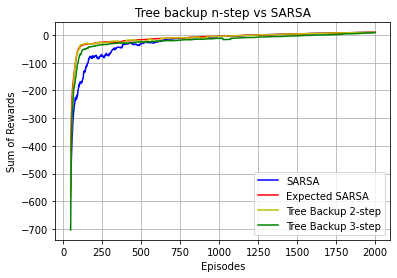

In [17]:
df_expected_sarsa = pd.DataFrame(data=np.mean(expected_sarsa_agent.reward_of_all_episodes, axis=0), index=range(num_of_episodes))
df_sarsa = pd.DataFrame(data=np.mean(sarsa_agent.reward_of_all_episodes, axis=0), index=range(num_of_episodes))
df_tree_backup_2step_agent = pd.DataFrame(data=np.mean(tree_backup_2step_agent.reward_of_all_episodes, axis=0), index=range(num_of_episodes))
df_tree_backup_3step_agent = pd.DataFrame(data=np.mean(tree_backup_3step_agent.reward_of_all_episodes, axis=0), index=range(num_of_episodes))

expected_sarsa_moving = df_expected_sarsa.rolling(window=window_size).mean()
sarsa_moving = df_sarsa.rolling(window=window_size).mean()
tree_backup_2step_moving = df_tree_backup_2step_agent.rolling(window=window_size).mean()
tree_backup_3step_moving = df_tree_backup_3step_agent.rolling(window=window_size).mean()

plt.title('Tree backup n-step vs SARSA')
plt.plot(sarsa_moving, 'b', label='SARSA')
plt.plot(expected_sarsa_moving, 'r', label='Expected SARSA')
plt.plot(tree_backup_2step_moving, 'y', label='Tree Backup 2-step')
plt.plot(tree_backup_3step_moving, 'g', label='Tree Backup 3-step')
plt.ylabel('Sum of Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.grid()
plt.show()

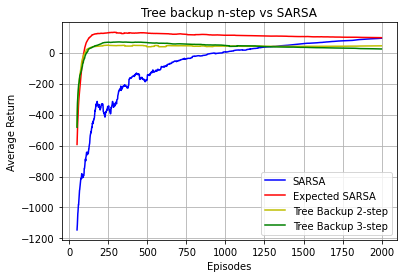

In [18]:
df_expected_sarsa = pd.DataFrame(data=np.mean(expected_sarsa_agent.gt_of_all_episodes, axis=0), index=range(num_of_episodes))
df_sarsa = pd.DataFrame(data=np.mean(sarsa_agent.gt_of_all_episodes, axis=0), index=range(num_of_episodes))
df_tree_backup_2step_agent = pd.DataFrame(data=np.mean(tree_backup_2step_agent.gt_of_all_episodes, axis=0), index=range(num_of_episodes))
df_tree_backup_3step_agent = pd.DataFrame(data=np.mean(tree_backup_3step_agent.gt_of_all_episodes, axis=0), index=range(num_of_episodes))

expected_sarsa_moving = df_expected_sarsa.rolling(window=window_size).mean()
sarsa_moving = df_sarsa.rolling(window=window_size).mean()
tree_backup_2step_moving = df_tree_backup_2step_agent.rolling(window=window_size).mean()
tree_backup_3step_moving = df_tree_backup_3step_agent.rolling(window=window_size).mean()

plt.title('Tree backup n-step vs SARSA')
plt.plot(sarsa_moving, 'b', label='SARSA')
plt.plot(expected_sarsa_moving, 'r', label='Expected SARSA')
plt.plot(tree_backup_2step_moving, 'y', label='Tree Backup 2-step')
plt.plot(tree_backup_3step_moving, 'g', label='Tree Backup 3-step')
plt.ylabel('Average Return')
plt.xlabel('Episodes')
plt.legend()
plt.grid()
plt.show()

In [19]:
np.savetxt('q1.out', sarsa_agent.q_values.reshape(1,6*500), delimiter=',')
np.savetxt('q2.out', expected_sarsa_agent.q_values.reshape(1,6*500), delimiter=',')
np.savetxt('q3.out', tree_backup_2step_agent.q_values.reshape(1,6*500), delimiter=',')
np.savetxt('q4.out', tree_backup_3step_agent.q_values.reshape(1,6*500), delimiter=',')